# 4辐照度预测———LSTM 结构模型

In [1]:
import os
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot_ng as pydot
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,Flatten,Conv1D,MaxPooling1D,SimpleRNN,GRU
from keras.utils import np_utils,plot_model
from keras.models import model_from_json
# from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import svm
from keras.layers.core import Dense, Activation, Dropout
from sklearn.externals import joblib
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKA-WeatherStation


In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation.csv',
 '1辐照度预测——数据提取重组融合.ipynb',
 '2009-2018暂存辐照度.csv',
 '2009-2018辐照度.csv',
 '2009-2018辐照度（每15min）.csv',
 '2009-2018辐照度（每15min）d+(d+1).csv',
 '2009按天辐照度.csv',
 '2010按天辐照度.csv',
 '2011辐照度.csv',
 '2011辐照度（每15min）.csv',
 '2011辐照度（每15min）d+(d+1).csv',
 '2辐照度预测———异常值空缺值融合构建训练集测试集.ipynb',
 '3辐照度预测———训练模型搭建.ipynb',
 '4辐照度预测———LSTM 结构模型.ipynb',
 'aaa.py',
 'CNN101.h5',
 'CNNLSTM106.h5',
 'DNN101.h5',
 'H5',
 'kpi',
 'LSTM102.h5',
 'model.png',
 'model.svg',
 'picture']

In [5]:
readdata = pd.read_csv('2009-2018辐照度（每15min）d+(d+1).csv')

In [6]:
readdata.head(3)

,Timestamp(d),Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009/1/1,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009/1/2,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009/1/3,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905


In [7]:
readdata.shape

(3535, 108)

In [8]:
print(list(readdata))

['Timestamp(d)', 'Year(d)', 'Month(d)', 'Day(d)', '7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '1

In [9]:
# data2016=readdata.loc[readdata['Year(d)']==2016].copy()
data2016=readdata.copy()


In [10]:
data2016.head

<bound method NDFrame.head of      Timestamp(d)  Year(d)  Month(d)  Day(d)     7:0.(d)    7:15.(d)  \
0        2009/1/1     2009         1       1   69.547572  172.525439   
1        2009/1/2     2009         1       2  217.125041  286.694814   
2        2009/1/3     2009         1       3  198.361186  268.127340   
3        2009/1/4     2009         1       4  197.530614  263.462957   
4        2009/1/5     2009         1       5  192.138123  258.078491   
5        2009/1/6     2009         1       6  190.245458  255.405726   
6        2009/1/7     2009         1       7  190.891327  252.880096   
7        2009/1/8     2009         1       8  105.413287  167.696205   
8        2009/1/9     2009         1       9  155.561157  216.828557   
9       2009/1/10     2009         1      10  181.363439  248.468155   
10      2009/1/11     2009         1      11  191.673426  261.160055   
11      2009/1/12     2009         1      12  194.391897  263.926071   
12      2009/1/13     2009        

# keras模型训练

In [11]:
print(list(data2016))

['Timestamp(d)', 'Year(d)', 'Month(d)', 'Day(d)', '7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '1

In [12]:
data2016.drop(columns='Timestamp(d)')

,Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),8:30.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,317.706991,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,586.624146,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,583.132365,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905
3,2009,1,4,197.530614,263.462957,325.515991,381.755819,440.651398,498.782481,554.108846,...,145.663063,124.460625,89.832476,56.051145,30.281507,26.159934,14.963341,8.348274,5.085345,4.080695
4,2009,1,5,192.138123,258.078491,321.122915,378.862813,436.805511,498.423320,556.736471,...,265.356323,249.234929,182.835882,154.042969,198.114629,113.686554,52.938282,25.614613,7.622757,3.752770
5,2009,1,6,190.245458,255.405726,317.514587,373.904215,433.374898,488.775625,548.296855,...,91.731679,87.453443,110.178597,75.847331,51.487726,41.561773,33.699253,21.592031,5.642986,4.580985
6,2009,1,7,190.891327,252.880096,313.902059,369.186920,311.354390,290.014130,251.575343,...,374.711690,299.308528,215.966263,144.843908,104.836009,79.247098,36.090487,13.582575,5.886935,3.925524
7,2009,1,8,105.413287,167.696205,278.562195,300.617564,425.772105,419.340612,582.940104,...,364.297770,303.693654,242.815491,181.319366,123.433632,74.083536,36.869883,14.619606,6.568018,4.278584
8,2009,1,9,155.561157,216.828557,278.723094,340.870514,400.820363,466.674438,526.366506,...,378.057983,317.581116,257.372065,194.881231,134.933334,82.799632,41.159291,16.367856,6.824109,5.221718
9,2009,1,10,181.363439,248.468155,317.807119,375.967794,434.610118,499.531606,559.794535,...,384.761688,325.966166,263.072200,200.024226,139.220225,85.837463,42.217292,15.878043,7.443807,5.923368


In [13]:
data2016.head()

,Timestamp(d),Year(d),Month(d),Day(d),7:0.(d),7:15.(d),7:30.(d),7:45.(d),8:0.(d),8:15.(d),...,17:30.(d+1),17:45.(d+1),18:0.(d+1),18:15.(d+1),18:30.(d+1),18:45.(d+1),19:0.(d+1),19:15.(d+1),19:30.(d+1),19:45.(d+1)
0,2009/1/1,2009,1,1,69.547572,172.525439,346.184418,431.466736,399.969879,286.426025,...,370.609670,309.659342,247.962784,186.269068,128.375224,76.873255,34.446934,13.963012,6.609656,4.661077
1,2009/1/2,2009,1,2,217.125041,286.694814,348.620951,406.212087,464.882568,526.545258,...,396.843872,342.717072,263.926905,195.593023,132.444580,77.939009,44.119278,19.040752,6.297939,3.578515
2,2009/1/3,2009,1,3,198.361186,268.127340,336.591858,395.856018,456.667145,519.893545,...,375.296550,229.727109,251.156123,214.154139,161.210236,57.794492,28.367191,11.132816,5.073857,2.746905
3,2009/1/4,2009,1,4,197.530614,263.462957,325.515991,381.755819,440.651398,498.782481,...,145.663063,124.460625,89.832476,56.051145,30.281507,26.159934,14.963341,8.348274,5.085345,4.080695
4,2009/1/5,2009,1,5,192.138123,258.078491,321.122915,378.862813,436.805511,498.423320,...,265.356323,249.234929,182.835882,154.042969,198.114629,113.686554,52.938282,25.614613,7.622757,3.752770


# 归一化

In [14]:
train=data2016.drop(columns=['Timestamp(d)','Year(d)', 'Month(d)', 'Day(d)']).copy()

In [15]:
print(list(train))

['7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '12:15.(d+1)', '12:30.(d+1)', '12:45.(d+1)', '13:0.

In [16]:
print(list(train).index('7:0.(d)'))
print(list(train).index('7:0.(d+1)'))
print(list(train).index('19:45.(d+1)'))

0
52
103


In [17]:
(list(train).index('7:0.(d)'))

0

In [18]:
train1 = train.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

# test1 = test1.values
# test1 = test1.astype('float32')     # 将整型变为float
# scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
# test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]

In [19]:
print(list(train))

['7:0.(d)', '7:15.(d)', '7:30.(d)', '7:45.(d)', '8:0.(d)', '8:15.(d)', '8:30.(d)', '8:45.(d)', '9:0.(d)', '9:15.(d)', '9:30.(d)', '9:45.(d)', '10:0.(d)', '10:15.(d)', '10:30.(d)', '10:45.(d)', '11:0.(d)', '11:15.(d)', '11:30.(d)', '11:45.(d)', '12:0.(d)', '12:15.(d)', '12:30.(d)', '12:45.(d)', '13:0.(d)', '13:15.(d)', '13:30.(d)', '13:45.(d)', '14:0.(d)', '14:15.(d)', '14:30.(d)', '14:45.(d)', '15:0.(d)', '15:15.(d)', '15:30.(d)', '15:45.(d)', '16:0.(d)', '16:15.(d)', '16:30.(d)', '16:45.(d)', '17:0.(d)', '17:15.(d)', '17:30.(d)', '17:45.(d)', '18:0.(d)', '18:15.(d)', '18:30.(d)', '18:45.(d)', '19:0.(d)', '19:15.(d)', '19:30.(d)', '19:45.(d)', '7:0.(d+1)', '7:15.(d+1)', '7:30.(d+1)', '7:45.(d+1)', '8:0.(d+1)', '8:15.(d+1)', '8:30.(d+1)', '8:45.(d+1)', '9:0.(d+1)', '9:15.(d+1)', '9:30.(d+1)', '9:45.(d+1)', '10:0.(d+1)', '10:15.(d+1)', '10:30.(d+1)', '10:45.(d+1)', '11:0.(d+1)', '11:15.(d+1)', '11:30.(d+1)', '11:45.(d+1)', '12:0.(d+1)', '12:15.(d+1)', '12:30.(d+1)', '12:45.(d+1)', '13:0.

In [20]:
train_X, train_y = train1[train1_inds,(list(train).index('7:0.(d)')):(list(train).index('7:0.(d+1)'))], train1[train1_inds,(list(train).index('7:0.(d+1)')):]
eval_X,eval_y = train1[eval1_inds,(list(train).index('7:0.(d)')):(list(train).index('7:0.(d+1)'))], train1[eval1_inds,(list(train).index('7:0.(d+1)')):]
#reshape for CNN model
train_X_c = np.expand_dims(train_X, axis=2)#增加一维轴
eval_X_c = np.expand_dims(eval_X, axis=2)

#reshape input to be 3D [samples,timsteps,features]
train_X_l = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
eval_X_l = eval_X.reshape((eval_X.shape[0],1,eval_X.shape[1]))


In [21]:
print(train_X.shape, train_y.shape,eval_X.shape,eval_y.shape)
print(train_X_c.shape, train_y.shape,eval_X_c.shape,eval_y.shape)
print(train_X_l.shape, train_y.shape,eval_X_l.shape,eval_y.shape)

(2828, 52) (2828, 52) (707, 52) (707, 52)
(2828, 52, 1) (2828, 52) (707, 52, 1) (707, 52)
(2828, 1, 52) (2828, 52) (707, 1, 52) (707, 52)


In [22]:
train_X.shape[1]

52

# LSTM 

In [23]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
print(model.summary())

lstmstart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstmend = time.clock()

history_lstm = history
modellstm = model
modellstm.save('./H5/LSTM.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 128)               92672     
_________________________________________________________________
Output (Dense)               (None, 52)                6708      
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________
None


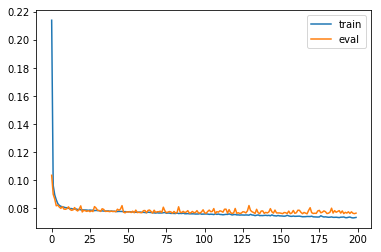

In [24]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM Relu

In [26]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='relu',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='relu',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstmrelustart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstmreluend = time.clock()

history_lstmrelu = history
modellstmrelu = model
# modellstmrelu.save('./H5/LSTM.h5')

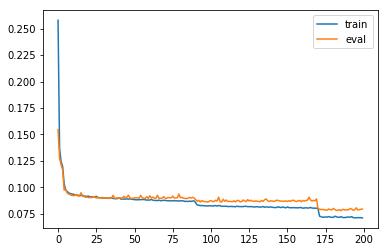

In [27]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM sigmoid

In [29]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='sigmoid',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='sigmoid',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstmsigmoidstart = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstmsigmoidend = time.clock()

history_lstmsigmoid = history
modellstmsigmoid = model
# modellstmsigmoid.save('./H5/LSTM.h5')

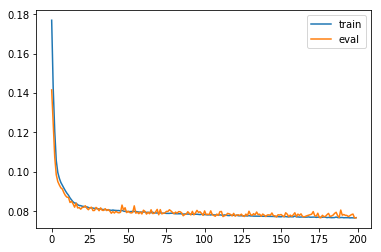

In [30]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM RMSporp

In [32]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstmrmspropstart = time.clock()
model.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstmrmspropend = time.clock()

history_lstmrmsprop = history
modellstmrmsprop = model
# modellstmrmsprop.save('./H5/LSTM.h5')

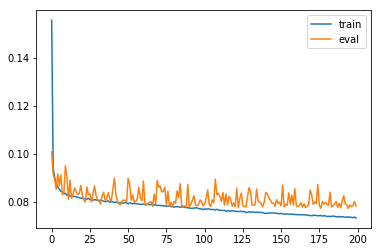

In [33]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM 256

In [35]:
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstm256start = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstm256end = time.clock()

history_lstm256 = history
modellstm256 = model
# modellstm256.save('./H5/LSTM.h5')

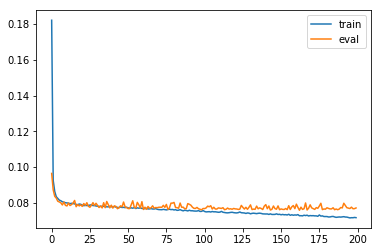

In [36]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM 64

In [38]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstm64start = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstm64end = time.clock()

history_lstm64 = history
modellstm64 = model
# modellstm64.save('./H5/LSTM.h5')

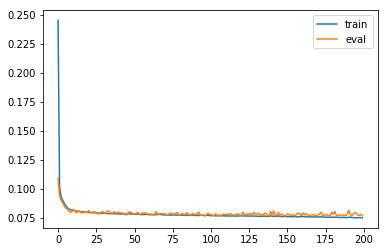

In [39]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM 32

In [41]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
# print(model.summary())

lstm32start = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstm32end = time.clock()

history_lstm32 = history
modellstm32 = model
# modellstm32.save('./H5/LSTM.h5')

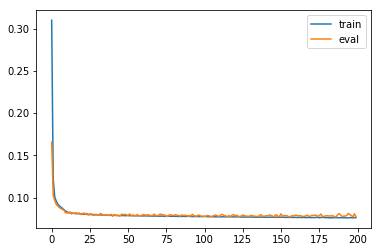

In [42]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM 两层

In [44]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1',return_sequences=True))
model.add(LSTM(64,return_sequences=False,name='LSTM2',use_bias = True))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
plot_model(model,to_file="./picture/LSTM_model_两层.svg",show_shapes=True)
print(model.summary())

lstm2start = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstm2end = time.clock()

history_lstm2 = history
modellstm2 = model
# modellstm2.save('./H5/LSTM.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 1, 128)            92672     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 64)                49408     
_________________________________________________________________
Output (Dense)               (None, 52)                3380      
Total params: 145,460
Trainable params: 145,460
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# model = Sequential()
# model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# model.add(LSTM(32,return_sequences=True))
# model.add(LSTM(16,return_sequences=False))
# # model.add(Dense(units=1,activation='tanh'))

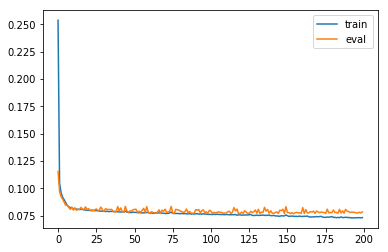

In [46]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

# LSTM 三层

In [48]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X_l.shape[1], train_X_l.shape[2]),activation='tanh',use_bias = True,name='LSTM1',return_sequences=True))

model.add(LSTM(64,return_sequences=True,use_bias = True,name='LSTM2'))
model.add(LSTM(32,return_sequences=False,use_bias = True,name='LSTM3'))
model.add(Dense(units=train_y.shape[1],activation='tanh',use_bias = True,name='Output'))

# plot_model(model,to_file="./picture/LSTM_model_%s.svg"%str(time.clock()).split('.')[0],show_shapes=True)
plot_model(model,to_file="./picture/LSTM_model三层.svg",show_shapes=True)
print(model.summary())

lstm3start = time.clock()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
# history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y), verbose=2, shuffle=False)
history = model.fit(train_X_l, train_y, epochs=200, batch_size=64, validation_data=(eval_X_l, eval_y),verbose=0)
lstm3end = time.clock()

history_lstm3 = history
modellstm3 = model
# modellstm3.save('./H5/LSTM.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 1, 128)            92672     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 1, 64)             49408     
_________________________________________________________________
LSTM3 (LSTM)                 (None, 32)                12416     
_________________________________________________________________
Output (Dense)               (None, 52)                1716      
Total params: 156,212
Trainable params: 156,212
Non-trainable params: 0
_________________________________________________________________
None


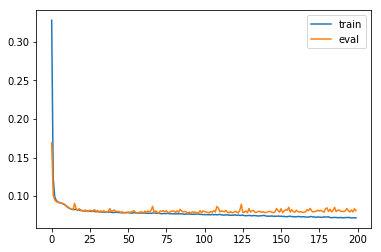

In [49]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

In [50]:
# keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

# 画出各个模型的网络结构并保存

In [51]:
# plot_model(model,to_file="./picture/DNN_model.svg",show_shapes=True)

# 输出各网络模型参数

In [52]:
# modellstmsigmoid,modellstmrelu,modellstmrmsprop,modellstm256,modellstm64,modellstm32,modellstm2,modellstm3

# 预测验证集

In [53]:
##预测lstm
lstm_pred = modellstm.predict(eval_X_l)

In [54]:
##预测lstmsigmoid
lstmsigmoid_pred = modellstmsigmoid.predict(eval_X_l)

In [55]:
##预测lstmrelu
lstmrelu_pred = modellstmrelu.predict(eval_X_l)

In [56]:
##预测lstmrmsprop
lstmrmsprop_pred = modellstmrmsprop.predict(eval_X_l)

In [57]:
##预测lstm256
lstm256_pred = modellstm256.predict(eval_X_l)

In [58]:
##预测lstm64
lstm64_pred = modellstm64.predict(eval_X_l)

In [59]:
##预测lstm32
lstm32_pred = modellstm32.predict(eval_X_l)

In [60]:
##预测lstm2
lstm2_pred = modellstm2.predict(eval_X_l)

In [61]:
##预测lstm3
lstm3_pred = modellstm3.predict(eval_X_l)

# 

In [62]:
eval_y[31,:]

array([0.71224296, 0.8815317 , 0.73962724, 0.8920744 , 0.99999994,
       0.9872067 , 0.8103784 , 0.8953931 , 0.8897425 , 0.87661856,
       0.87094563, 0.8960222 , 0.7526276 , 0.40177542, 0.72785884,
       0.76042145, 0.7314716 , 0.827008  , 0.544545  , 0.4045371 ,
       0.57363063, 0.75270915, 0.7422565 , 0.79504025, 0.47254303,
       0.27658242, 0.20437826, 0.27391422, 0.23093376, 0.22801332,
       0.29393137, 0.41922975, 0.5004783 , 0.2767546 , 0.31258225,
       0.30296624, 0.37274158, 0.40876237, 0.36609438, 0.3714468 ,
       0.2439024 , 0.40119326, 0.4316948 , 0.2815615 , 0.2307024 ,
       0.1824571 , 0.14234823, 0.11807689, 0.07225984, 0.07709261,
       0.0966825 , 0.13182884], dtype=float32)

In [63]:
# fig = plt.figure(figsize=(6,4.5))
# ax=fig.add_subplot(1,1,1)

# plt.plot(eval_y[31,:],label='Real',linestyle='-')
# plt.plot(dnn_pred[31,:],label='DNN',linestyle='--')
# plt.plot(cnn_pred[31,:],label='CNN',linestyle='-.')
# plt.plot(lstm_pred[31,:],label='LSTM',linestyle=':')
# # plt.plot(cnnlstm_pred[31,:],label='CNN-LSTM',linestyle='-.')

# plt.plot(rnn_pred[31,:],label='RNN',linestyle='--')
# plt.plot(gru_pred[31,:],label='GRU',linestyle=':')

# plt.legend()

# plt.savefig('./picture/多结构归一化预测.jpg',dpi=300)
# plt.savefig('./picture/多结构归一化预测.svg',format="svg",dpi=300)

# 反归一化

In [64]:
# print(' eval_X  cnn_pred eval_y.shape train1.shape\n',
#       eval_X.shape,cnn_pred.shape,eval_y.shape, train1.shape)

In [65]:
train_X.shape[1]

52

In [66]:
##定义反归一化函数
def inv(Predict,eval_X,eval_y,train_X,train_y):
#     X = np.squeeze(X)
    
    invpre_xy = concatenate((eval_X,Predict), axis=1)
    inveval_xy = concatenate((eval_X,eval_y),axis=1)
    invtrain_xy = concatenate((train_X,train_y),axis=1)
    
    # invert scaling for forecast
    invpredict = concatenate((invtrain_xy,invpre_xy),axis=0)
    invpredict = scaler.inverse_transform(invpredict)
    predict = invpredict[train_X.shape[0]:,train_X.shape[1]:]
    # invert scaling for actual
    invture = concatenate((invtrain_xy,inveval_xy),axis=0)
    invture = scaler.inverse_transform(invture)
    real = invture[train_X.shape[0]:,train_X.shape[1]:]
    return predict,real

In [67]:
# modellstmsigmoid,modellstmrelu,modellstmrmsprop,modellstm256,modellstm64,modellstm32,modellstm2,modellstm3

In [68]:
##反归一化预测值 lstm
lstm_pred,y_true =inv(lstm_pred,eval_X,eval_y,train_X,train_y)

In [69]:
#反归一化 lstmsigmoid
lstmsigmoid_pred,y_true =inv(lstmsigmoid_pred,eval_X,eval_y,train_X,train_y)

In [70]:
#反归一化 lstmrelu
lstmrelu_pred,y_true =inv(lstmrelu_pred,eval_X,eval_y,train_X,train_y)

In [71]:
#反归一化 lstmrmsprop
lstmrmsprop_pred,y_true =inv(lstmrmsprop_pred,eval_X,eval_y,train_X,train_y)

In [72]:
#反归一化 lstm256
lstm256_pred,y_true =inv(lstm256_pred,eval_X,eval_y,train_X,train_y)

In [73]:
#反归一化 lstm64
lstm64_pred,y_true =inv(lstm64_pred,eval_X,eval_y,train_X,train_y)

In [74]:
#反归一化 lstm32
lstm32_pred,y_true =inv(lstm32_pred,eval_X,eval_y,train_X,train_y)

In [75]:
#反归一化 lstm2
lstm2_pred,y_true =inv(lstm2_pred,eval_X,eval_y,train_X,train_y)

In [76]:
#反归一化 lstm3
lstm3_pred,y_true =inv(lstm3_pred,eval_X,eval_y,train_X,train_y)

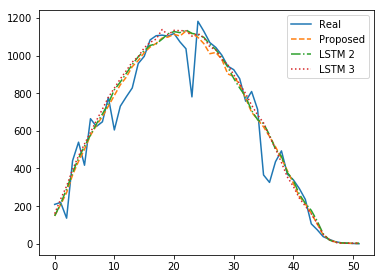

In [77]:
##反归一化预测值画图
fig = plt.figure(figsize=(6,4.5))
ax=fig.add_subplot(1,1,1)
plt.plot(y_true[22,:],label='Real',linestyle='-')
plt.plot(lstm64_pred[22,:],label='Proposed',linestyle='--')
plt.plot(lstm2_pred[22,:],label='LSTM 2',linestyle='-.')
plt.plot(lstm3_pred[22,:],label='LSTM 3',linestyle=':')
# plt.plot(cnnlstm_pred[20,:],label='CNN-LSTM',linestyle='-.')

# plt.plot(rnn_pred[20,:],label='RNN',linestyle='--')
# plt.plot(gru_pred[20,:],label='GRU',linestyle=':')

plt.legend()

# plt.savefig('./picture/多结构三层对比预测.jpg',dpi=300)
# plt.savefig('./picture/多结构三层对比预测.svg',format="svg",dpi=300)

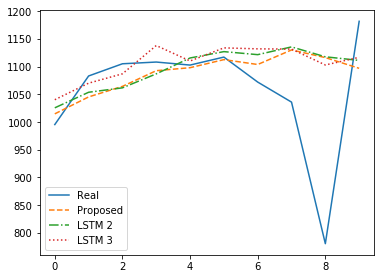

In [78]:
##反归一化预测值画图
fig = plt.figure(figsize=(6,4.5))
ax=fig.add_subplot(1,1,1)
plt.plot(y_true[22,15:25],label='Real',linestyle='-')
plt.plot(lstm64_pred[22,15:25],label='Proposed',linestyle='--')
plt.plot(lstm2_pred[22,15:25],label='LSTM 2',linestyle='-.')
plt.plot(lstm3_pred[22,15:25],label='LSTM 3',linestyle=':')
# plt.plot(cnnlstm_pred[20,15:22],label='CNN-LSTM',linestyle='-.')

# plt.plot(rnn_pred[20,15:22],label='RNN',linestyle='--')
# plt.plot(gru_pred[20,15:22],label='GRU',linestyle=':')

plt.legend()

# plt.savefig('./picture/多结构三层对比预测细节.jpg',dpi=300)
# plt.savefig('./picture/多结构三层对比预测细节.svg',format="svg",dpi=300)

In [79]:
# y_true.shape
# dnn_pred.shape
# cnn_pred.shape

# 按指标计算预测精度

In [80]:
# modellstmsigmoid,modellstmrelu,modellstmrmsprop,modellstm256,modellstm64,modellstm32,modellstm2,modellstm3

In [81]:
#计算LSTM 指标
## MSE计算
lstm_mse = metrics.mean_squared_error(y_true, lstm_pred)
##RMSE计算
lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred))
##MAE计算
lstm_mae = metrics.mean_absolute_error(y_true, lstm_pred)

In [82]:
#计算lstmsigmoid 指标
## MSE计算
lstmsigmoid_mse = metrics.mean_squared_error(y_true, lstmsigmoid_pred)
##RMSE计算
lstmsigmoid_rmse = np.sqrt(mean_squared_error(y_true, lstmsigmoid_pred))
##MAE计算
lstmsigmoid_mae = metrics.mean_absolute_error(y_true, lstmsigmoid_pred)

In [83]:
#计算lstmrelu 指标
## MSE计算
lstmrelu_mse = metrics.mean_squared_error(y_true, lstmrelu_pred)
##RMSE计算
lstmrelu_rmse = np.sqrt(mean_squared_error(y_true, lstmrelu_pred))
##MAE计算
lstmrelu_mae = metrics.mean_absolute_error(y_true, lstmrelu_pred)

In [84]:
#计算lstmrmsprop 指标
## MSE计算
lstmrmsprop_mse = metrics.mean_squared_error(y_true, lstmrmsprop_pred)
##RMSE计算
lstmrmsprop_rmse = np.sqrt(mean_squared_error(y_true, lstmrmsprop_pred))
##MAE计算
lstmrmsprop_mae = metrics.mean_absolute_error(y_true, lstmrmsprop_pred)

In [85]:
#计算lstm256 指标
## MSE计算
lstm256_mse = metrics.mean_squared_error(y_true, lstm256_pred)
##RMSE计算
lstm256_rmse = np.sqrt(mean_squared_error(y_true, lstm256_pred))
##MAE计算
lstm256_mae = metrics.mean_absolute_error(y_true, lstm256_pred)

In [86]:
#计算lstm64 指标
## MSE计算
lstm64_mse = metrics.mean_squared_error(y_true, lstm64_pred)
##RMSE计算
lstm64_rmse = np.sqrt(mean_squared_error(y_true, lstm64_pred))
##MAE计算
lstm64_mae = metrics.mean_absolute_error(y_true, lstm64_pred)

In [87]:
#计算lstm32 指标
## MSE计算
lstm32_mse = metrics.mean_squared_error(y_true, lstm32_pred)
##RMSE计算
lstm32_rmse = np.sqrt(mean_squared_error(y_true, lstm32_pred))
##MAE计算
lstm32_mae = metrics.mean_absolute_error(y_true, lstm32_pred)

In [88]:
#计算lstm2 指标
## MSE计算
lstm2_mse = metrics.mean_squared_error(y_true, lstm2_pred)
##RMSE计算
lstm2_rmse = np.sqrt(mean_squared_error(y_true, lstm2_pred))
##MAE计算
lstm2_mae = metrics.mean_absolute_error(y_true, lstm2_pred)

In [89]:
#计算lstm3 指标
## MSE计算
lstm3_mse = metrics.mean_squared_error(y_true, lstm3_pred)
##RMSE计算
lstm3_rmse = np.sqrt(mean_squared_error(y_true, lstm3_pred))
##MAE计算
lstm3_mae = metrics.mean_absolute_error(y_true, lstm3_pred)

# 生成对比表格

In [90]:
# modellstmsigmoid,modellstmrelu,modellstmrmsprop,modellstm256,modellstm64,modellstm32,modellstm2,modellstm3

In [91]:
#生成表格
comparison = pd.DataFrame(columns=['Model','RunTime(s)','MSE','RMSE','MAE'])

In [92]:
#lstm
comparison = comparison.append(pd.DataFrame({'Model':'LSTM','RunTime(s)':[lstmend-lstmstart],'MSE':[lstm_mse],
                                             'RMSE':[lstm_rmse],'MAE':[lstm_mae]}),ignore_index=False,sort=False)

In [93]:
#lstmsigmoid
comparison = comparison.append(pd.DataFrame({'Model':'LSTMsigmoid','RunTime(s)':[lstmsigmoidend-lstmsigmoidstart],'MSE':[lstmsigmoid_mse],
                                             'RMSE':[lstmsigmoid_rmse],'MAE':[lstmsigmoid_mae]}),ignore_index=False,sort=False)

In [94]:
#lstmrelu
comparison = comparison.append(pd.DataFrame({'Model':'LSTMrelu','RunTime(s)':[lstmreluend-lstmrelustart],'MSE':[lstmrelu_mse],
                                             'RMSE':[lstmrelu_rmse],'MAE':[lstmrelu_mae]}),ignore_index=False,sort=False)

In [95]:
#lstmrmsprop
comparison = comparison.append(pd.DataFrame({'Model':'LSTMRMSprop','RunTime(s)':[lstmrmspropend-lstmrmspropstart],'MSE':[lstmrmsprop_mse],
                                             'RMSE':[lstmrmsprop_rmse],'MAE':[lstmrmsprop_mae]}),ignore_index=False,sort=False)

In [96]:
#lstm256
comparison = comparison.append(pd.DataFrame({'Model':'LSTM256','RunTime(s)':[lstm256end-lstm256start],'MSE':[lstm256_mse],
                                             'RMSE':[lstm256_rmse],'MAE':[lstm256_mae]}),ignore_index=False,sort=False)

In [97]:
#lstm64
comparison = comparison.append(pd.DataFrame({'Model':'LSTM64','RunTime(s)':[lstm64end-lstm64start],'MSE':[lstm64_mse],
                                             'RMSE':[lstm64_rmse],'MAE':[lstm64_mae]}),ignore_index=False,sort=False)

In [98]:
#lstm32
comparison = comparison.append(pd.DataFrame({'Model':'LSTM32','RunTime(s)':[lstm32end-lstm32start],'MSE':[lstm32_mse],
                                             'RMSE':[lstm32_rmse],'MAE':[lstm32_mae]}),ignore_index=False,sort=False)

In [99]:
#lstm2
comparison = comparison.append(pd.DataFrame({'Model':'LSTM 2','RunTime(s)':[lstm2end-lstm2start],'MSE':[lstm2_mse],
                                             'RMSE':[lstm2_rmse],'MAE':[lstm2_mae]}),ignore_index=False,sort=False)

In [100]:
#lstm3
comparison = comparison.append(pd.DataFrame({'Model':'LSTM 3','RunTime(s)':[lstm3end-lstm3start],'MSE':[lstm3_mse],
                                             'RMSE':[lstm3_rmse],'MAE':[lstm3_mae]}),ignore_index=False,sort=False)

In [101]:
comparison

,Model,RunTime(s),MSE,RMSE,MAE
0,LSTM,109.855754,22510.914062,150.036377,71.648392
0,LSTMsigmoid,114.199125,21425.216797,146.373550,71.501007
0,LSTMrelu,113.299200,23443.888672,153.113968,74.683876
0,LSTMRMSprop,112.729051,23147.601562,152.143356,72.646332
0,LSTM256,153.319798,23150.123047,152.151642,72.572258
0,LSTM64,111.287807,22239.916016,149.130539,72.120163
0,LSTM32,110.945860,22117.865234,148.720764,71.979256
0,LSTM 2,172.612335,23328.199219,152.735718,74.036285
0,LSTM 3,226.989230,24897.072266,157.788055,76.726395


In [102]:
comparison.to_csv('./kpi/多结构比较结果%s.csv'%str(time.clock()).split('.')[0],index=False)

In [103]:
# #各个损失

# # plot history

# plt.plot(history_dnn.history['loss'], label='DNN_train')
# plt.plot(history_dnn.history['val_loss'], label='DNN_test')

# plt.plot(history_cnn.history['loss'], label='CNN_train')
# plt.plot(history_cnn.history['val_loss'], label='CNN_test')

# plt.plot(history_lstm.history['loss'], label='LSTM_train')
# plt.plot(history_lstm.history['val_loss'], label='LSTM_test')

# plt.legend()
# plt.show()